Le notebook précédent a donné comme résultats majeurs deux tableaux CSV. Ils contiennent tous les deux les informations de l'annuaire de propriétaires de 1951-52. L'un d'entre eux est indexé par rapport aux propriétaires, c'est-à-dire qu'une ligne du tableau correspond à un propriétaire. L'autre tableau est indexé par rapport aux immeubles parisiens, c'est-à-dire qu'une ligne de ce tableau correspond à un immeuble. Ces données ont été extraites automatiquement, et comporte donc des erreurs résiduelles.

<br>

***

<br>

Notre objectif est d'utiliser ces informations, ainsi que les informations de l'annuaire de propriétaire de l'année 1898, et de produire des cartes et statistiques pour étudier la propriété, multi-propriété et co-propriété à Paris, entre 1898 et 1951.

<br>

***

<br>

Les informations principales contenues dans le tableau indexé par propriétaires sont :
- le nom, prénom et la civilité du propriétaire (si il s'agit d'un particulier), ou le nom de l'organisation (si il s'agit d'une entreprise ou organisation). Ces colonnes sont nommées respectivement `nom_pers`, `prenom_pers`, `civilite_pers`, `org`
- l'adresse du propriétaire (qu'il s'agisse d'une personne physique ou d'une personne morale), est décomposée dans les colonnes `num_pers`, `type_voie_pers`, `nom_voie_pers`
- nous avons également en complément de cette adresse :
    - son arondissement si cette adresse se trouve à Paris, dans la colonne `arr_pers`
    - sa ville et sa localisation si cette adresse se trouve hors de Paris. Cette localisation peut etre un nom de département (en France) ou un nom de pays (฀à l'étranger), dans les colonnes `ville_pers` et `loc_pers`
- le statut de cette adresse (copropriété, indivision, etc.) dans `part_pers`
- nous avons ensuite les codes associées à cette personne, ou chaque code correspond à un ou plusieurs immeubles parisiens que cette personne possède, dans `nveaux_codes`, ainsi que le nombre de codes dans `nb_codes`. Ce nombre n'est pas à etre confondu avec `nb_imms`, qui compte le nombre d'immeubles différents que cette personne possède. (En effet, certains codes correspondent en réalité à plusieurs immeubles, quand ils se trouvent dans la meme rue)
- `coord_pers`, `lat_pers` et `lng_pers` correspondent aux coordonnées géographiques associées à l'adresse de la personne. Nous avons plus de détails sur les résultats du géocodeur utilisé (géocodeur du gouvernement) dans `result_type_pers` et `result_city_pers`
- `quartier_pers` contient le quartier associé à l'adresse du propriétaire.

<br>

Le tableau indexé par immeuble contient les memes informations, ainsi que des informations supplémentaires sur les immeubles possédés par chaque propriétaire. Les informations supplémentaires sont :
- l'adresse de l'immeuble décomposée dans `num_imm`, `type_voie_imm` et `nom_voie_imm`
- les coordonnées géographiques associées à cet immeuble par le géocodeur du gouvernement dans `lat_imm`, `lng_imm`, et `coord_imm` (ainsi que des informations supplémentaires sur la géolocalisation dans `result_type_imm` et `result_city_imm`)
- le quartier associé à l'adresse de l'immeuble dans `quartier_imm`
- les index `__index_pers__` et `index_total` sont identiques, et associe un numéro à chaque propriétaire

<br>

***

<br>

Nous nous servons d'un environnement avec :
- python version 3.10.14
- pandas version 2.1.3
- numpy version 1.26.4
- geopandas version 0.14.0
- folium version 0.15.0

# Etape 0 : Import des librairies et des données

## 1. Import des librairies

In [1]:
import pandas as pd
import geopandas
import numpy as np

import folium
from folium.plugins import MarkerCluster
from folium import Map
from folium.plugins import HeatMap

import matplotlib.pyplot as plt
plt.rc('axes', axisbelow=True)
import seaborn as sns

import os
import re

%matplotlib inline

pd.set_option('display.max_columns', None)


## 2. Import des données

In [2]:
# Définition des chemins utiles
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
path_quartiers = os.path.join(parent_dir, 'donnees_quartiers')

In [3]:
# Création d'un dossier pour sauvegarder les cartes et graphiques
path_fig = os.path.join(parent_dir, "cartes_et_figures")
os.mkdir(path_fig)

In [4]:
# Import du geodataframe contenant les quartiers et utilisation du numero d'arrondissement comme index
gdf_quartiers = geopandas.read_file(os.path.join(path_quartiers, 'quartier_paris.shp'), encoding='utf-8')
gdf_quartiers = gdf_quartiers.set_index('c_qu')
gdf_quartiers = gdf_quartiers.sort_index(axis=0)
gdf_quartiers = gdf_quartiers[['l_qu', 'c_ar', 'perimetre', 'surface', 'geometry']]

In [5]:
# Import des données des annuaires
df_imm_1898 = pd.read_csv(os.path.join(parent_dir, 'df_1898_av_quartiers.csv'))
df_imm_1951 = pd.read_csv(os.path.join(parent_dir, 'liste_proprios_1951/6_df_par_num_complet_1951.csv'))
df_proprio_1951 = pd.read_csv(os.path.join(parent_dir, 'liste_proprios_1951/6_df_par_proprio_complet_1951.csv'))

/tmp/ipykernel_113948/2512063787.py:2: DtypeWarning: Columns (9,11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_imm_1898 = pd.read_csv(os.path.join(parent_dir, 'df_1898_av_quartiers.csv'))


In [6]:
# Quelques modifications des dataframes :
# suppression d'une colonne inutile
df_proprio_1951 = df_proprio_1951.drop(["quartier_imm"], axis=1)


In [7]:
# Suppression des immeubles en double (quand 1 immeuble correspond a plusieurs adresses)
# Ne sert que pour 1898 car utilisation de l'annuaire ordonné par rues dans pipeline
print(f"Longueur df avant suppression : {len(df_imm_1898)}")
df_imm_1898 = df_imm_1898[df_imm_1898["Entree=0.1_Parisien=1.0_Nonparisien=0.0"] != 0.1]
print(f"Longueur df après suppression : {len(df_imm_1898)}")

Longueur df avant suppression : 104827
Longueur df après suppression : 88233


In [8]:
# Nous allons aussi produire un df_proprio_1898 qui contient une ligne pour un propriétaire unique
df_proprio_1898 = df_imm_1898.drop_duplicates(['code_pers'])

# Etape 1 : Production de statistiques et cartes générales

Nous allons dans un premier temps explorer les données.

In [9]:
nb_imm_1898 = len(df_imm_1898)
nb_imm_1951 = len(df_imm_1951)
nb_proprio_1898 = len(df_proprio_1898)
nb_proprio_1951 = len(df_proprio_1951)

aug_imm = round((nb_imm_1951 - nb_imm_1898)*100 / nb_imm_1951, 2)
aug_proprio = round((nb_proprio_1951 - nb_proprio_1898)*100 / nb_proprio_1951, 2)

nb_imm_p_moyen_1898 = round((nb_imm_1898 / nb_proprio_1898), 2)
nb_imm_p_moyen_1951 = round((nb_imm_1951 / nb_proprio_1951), 2)

print(f"Selon nos données, nous avons donc au total :\n- {nb_imm_1898} immeubles à Paris en 1898, et {nb_imm_1951} en 1951, ce qui représente une augmentation de {aug_imm}% ;\n- {nb_proprio_1898} propriétaires différents d'immeubles parisiens en 1898, et {nb_proprio_1951} en 1951, ce qui représente une augmentation de {aug_proprio}%.")

print(f"\nEt un propriétaire possède en moyenne :\n- {nb_imm_p_moyen_1898} immeubles en 1898,\n- {nb_imm_p_moyen_1951} en 1951.")

Selon nos données, nous avons donc au total :
- 88233 immeubles à Paris en 1898, et 108056 en 1951, ce qui représente une augmentation de 18.35% ;
- 41542 propriétaires différents d'immeubles parisiens en 1898, et 53017 en 1951, ce qui représente une augmentation de 21.64%.

Et un propriétaire possède en moyenne :
- 2.12 immeubles en 1898,
- 2.04 en 1951.


## A. Cartes du nombre d'immeubles total en 1898 et 1951, et de la l'évolution entre les deux

Nous allons nous intéresser à la répartition du nombre d'immeuble par quartier en 1898 et 1951, et comparer ces chiffres.

### 1. Carte du nombre d'immeuble par quartier en 1898, en valeur absolue

In [11]:
# On regarde la distribution du nombre d'immeuble par quartier en 1898
gdf_quartiers.nb_immeubles_1898.describe()

count      80.000000
mean     1090.937500
std       604.628798
min       280.000000
25%       614.000000
50%       938.500000
75%      1374.500000
max      2814.000000
Name: nb_immeubles_1898, dtype: float64

In [12]:
# On créé la carte
base_map = folium.Map(location=[48.86, 2.345], zoom_start=12, tiles="CartoDB positron")

min = gdf_quartiers.nb_immeubles_1898.min()
max = gdf_quartiers.nb_immeubles_1898.max()

m = gdf_quartiers.explore(
    column="nb_immeubles_1898",
    cmap='Reds',
    m=base_map,
    tooltip=["c_qu", "nb_immeubles_1898"],
    popup=True,
    categorical=False,
    vmin=min,
    vmax=max,
    style_kwds=dict(color="grey"),
    legend_kwds=dict(caption="Nombre total d'immeubles par quartier en 1898")
)
m.save(os.path.join(path_fig, "nb_imm_total_1898.html"))
m

### 2. Carte du nombre d'immeuble par quartier en 1951, en valeur absolue

In [13]:
# Distribution
gdf_quartiers.nb_immeubles_1951.describe()

count      80.000000
mean     1325.812500
std       771.561364
min       291.000000
25%       708.750000
50%      1117.000000
75%      1844.250000
max      3483.000000
Name: nb_immeubles_1951, dtype: float64

In [14]:
# Carte
base_map = folium.Map(location=[48.86, 2.345], zoom_start=12, tiles="CartoDB positron")

min = gdf_quartiers.nb_immeubles_1951.min()
max = gdf_quartiers.nb_immeubles_1951.max()

m = gdf_quartiers.explore(
    column="nb_immeubles_1951",
    cmap='Reds',
    m=base_map,
    tooltip=["c_qu", "nb_immeubles_1951"],
    popup=True,
    categorical=False,
    vmin=min,
    vmax=max,
    style_kwds=dict(color="grey"),
    legend_kwds=dict(caption="Nombre total d'immeubles par quartier en 1951")
)
m.save(os.path.join(path_fig, "nb_imm_total_1951.html"))
m

### 3. Carte de la différence entre le nombre d'immeubles en 1898 et en 1951

On va soustraire le nombre total d'immeubles par quartier en 1951 aux chiffres de 1898, pour observer quelles sont les dynamiques dans la construction et destruction de batiments, par quartier.

In [15]:
# def nouvelle colonne correspondante
gdf_quartiers['diff_nb_imm'] = gdf_quartiers['nb_immeubles_1951'] - gdf_quartiers['nb_immeubles_1898']

In [16]:
# distribution
gdf_quartiers.diff_nb_imm.describe()

count      80.00000
mean      234.87500
std       289.16805
min      -420.00000
25%        75.50000
50%       163.50000
75%       290.75000
max      1378.00000
Name: diff_nb_imm, dtype: float64

In [17]:
# carte
base_map = folium.Map(location=[48.86, 2.345], zoom_start=12, tiles="CartoDB positron")

min = gdf_quartiers.diff_nb_imm.min()
max = gdf_quartiers.diff_nb_imm.max()

m = gdf_quartiers.explore(
    column="diff_nb_imm",
    cmap='Reds',
    m=base_map,
    tooltip=["c_qu", "nb_immeubles_1898", "nb_immeubles_1951", "diff_nb_imm"],
    popup=True,
    categorical=False,
    vmin=min,
    vmax=max,
    style_kwds=dict(color="grey"),
    legend_kwds=dict(caption="Différence dans le nombre d'immeuble total par quartier entre 1898 et 1951")
)
m.save(os.path.join(path_fig, "diff_nb_imm_total.html"))
m

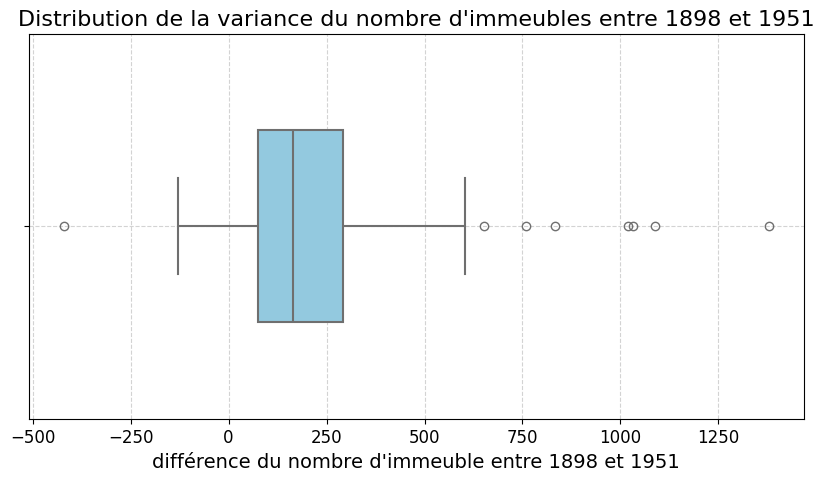

In [18]:
# Histogramme de la distribution de la différence du nombre d'immeubles entre 1898 et 1951
plt.figure(figsize=(10, 5))

sns.boxplot(x='diff_nb_imm', data=gdf_quartiers, color='skyblue', linewidth=1.5, width=0.5)

plt.xlabel('différence du nombre d\'immeuble entre 1898 et 1951', fontsize=14)
plt.title('Distribution de la variance du nombre d\'immeubles entre 1898 et 1951', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(color='lightgrey', linestyle='--')  # Set grid color and linestyle

plt.savefig(os.path.join(path_fig, "distr_diff_nb_imm.jpeg"), dpi=100)
plt.show()

### 4. Comparaison des cinq quartiers avec le plus d'immeubles, en 1898 et 1951

In [19]:
gdf_quartiers.nb_immeubles_1898.sort_values(ascending=False).head(5)

c_qu
70.0    2814.0
56.0    2737.0
50.0    2365.0
69.0    2288.0
79.0    2264.0
Name: nb_immeubles_1898, dtype: float64

In [20]:
gdf_quartiers.nb_immeubles_1951.sort_values(ascending=False).head(5)

c_qu
57.0    3483.0
70.0    3466.0
69.0    3321.0
61.0    3055.0
56.0    2889.0
Name: nb_immeubles_1951, dtype: float64

## B. Cartes de la densité d'immeubles par rapport à la surface, par quartier

### 1. Carte de la densité du nombre d'immeuble par rapport à la surface, par quartier, en 1898

In [21]:
# rajout de colonnes de densité du nombre d'immeubles par rapport à la surface
gdf_quartiers['densite_immeubles_1898'] = gdf_quartiers["nb_immeubles_1898"]/gdf_quartiers['surface']
gdf_quartiers['densite_immeubles_1951'] = gdf_quartiers["nb_immeubles_1951"]/gdf_quartiers['surface']

In [22]:
# Distribution
gdf_quartiers['densite_immeubles_1898'].describe()

count    80.000000
mean      0.001188
std       0.000615
min       0.000153
25%       0.000844
50%       0.001113
75%       0.001534
max       0.003432
Name: densite_immeubles_1898, dtype: float64

In [23]:
# Carte
base_map = folium.Map(location=[48.86, 2.345], zoom_start=12, tiles="CartoDB positron")

min = gdf_quartiers.densite_immeubles_1898.min()
max = gdf_quartiers.densite_immeubles_1898.max()

m = gdf_quartiers.explore(
    column="densite_immeubles_1898",
    cmap='Reds',
    m=base_map,
    tooltip=["c_qu", "nb_immeubles_1898", "surface", "densite_immeubles_1898"],
    popup=True,
    categorical=False,
    vmin=min,
    vmax=max,
    style_kwds=dict(color="grey"),
    legend_kwds=dict(caption="Densité des immeubles par rapport à la surface en 1898")
)
m.save(os.path.join(path_fig, "densite_imm_surface_1898.html"))
m

### 2. Carte de la densité du nombre d'immeuble par rapport à la surface, par quartier, en 1951

In [24]:
# Distribution
gdf_quartiers['densite_immeubles_1951'].describe()

count    80.000000
mean      0.001426
std       0.000753
min       0.000197
25%       0.000997
50%       0.001311
75%       0.001817
max       0.003908
Name: densite_immeubles_1951, dtype: float64

In [25]:
# Carte
base_map = folium.Map(location=[48.86, 2.345], zoom_start=12, tiles="CartoDB positron")

min = gdf_quartiers.densite_immeubles_1951.min()
max = gdf_quartiers.densite_immeubles_1951.max()

m = gdf_quartiers.explore(
    column="densite_immeubles_1951",
    cmap='Reds',
    m=base_map,
    tooltip=["c_qu", "nb_immeubles_1951", "surface", "densite_immeubles_1951"],
    popup=True,
    categorical=False,
    vmin=min,
    vmax=max,
    style_kwds=dict(color="grey"),
    legend_kwds=dict(caption="Densité des immeubles par rapport à la surface en 1951")
)
m.save(os.path.join(path_fig, "densite_imm_surface_1951.html"))
m

# Etape 2 : Adaptation de nos données à une étude sur la multi-propriété, et quelques statistiques

Nous allons maintenant nous concentrer sur les multi-propriétaires. Nous allons d'abord adapter nos données à notre étude :
- création d'un index unique pour les propriétaires dans les dataframes de 1898
- création d'une colonne qui compte combien d'immeuble.s chaque propriétaire possède dans le dataframe de 1951 indexé par propriétaire
- création de dataframes ne contenant que les multi-propriétaires

Nous allons ensuite nous en servir pour produire des cartes et pouvoir localiser et étudier ce phénomène.

Les deux dataframes de multi-propriétaires que nous utilisons contiennent des propriétaires étant des personnes physiques et des personnes morales, donc ils nous semblent donc comparables.

## A. Préparation de nos données à l'étude sur les multi-propriétaires

In [26]:
# Création d'un "code_total" qui concatène code_pers et code_org pour que chaque propriétaire ait un code_total unique
def calculate_index_total(row):
    if row['code_pers'] in [0, 1]:
        if row['code_org'] in [0, 1]:
            pass
        else:
            return row['code_org'] + 41750
    else:
        return row['code_pers']

df_imm_1898['code_total'] = df_imm_1898.apply(calculate_index_total, axis=1)
df_proprio_1898['code_total'] = df_proprio_1898.apply(calculate_index_total, axis=1)

/tmp/ipykernel_113948/3520158351.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proprio_1898['code_total'] = df_proprio_1898.apply(calculate_index_total, axis=1)


In [27]:
# Création d'une colonne qui compte combien d'immeuble chaque proprietaire possède
counts = df_imm_1898['code_total'].value_counts()
counts.columns = ['code_total', 'nb_imms']
df_proprio_1898 = df_proprio_1898.merge(counts, on='code_total', how='left')
df_proprio_1898 = df_proprio_1898.rename(columns={'count': 'nb_imms'})

In [28]:
# Définition des dataframes de multi-propriétaires
df_MP_proprio_1898 = df_proprio_1898.loc[df_proprio_1898.nb_imms >= 2]
df_MP_proprio_1951 = df_proprio_1951.loc[df_proprio_1951.nb_imms >= 2]

## B. Histogrammes de la distribution du nombre d'immeuble par propriétaire, en 1898 et en 1951

In [29]:
nb_proprio_1898 = len(df_proprio_1898)
nb_MP_1898 = len(df_MP_proprio_1898)
nb_proprio_1951 = len(df_proprio_1951)
nb_MP_1951 = len(df_MP_proprio_1951)
pour_MP_1898 = round(nb_MP_1898*100 / (nb_proprio_1898), 2)
pour_MP_1951 = round(nb_MP_1951*100 / (nb_proprio_1951), 2)

print(f"Selon nos données, nous avons :\n- {nb_proprio_1898} propriétaires différents en 1898, dont {nb_MP_1898} multi-propriétaires, c'est-à-dire {pour_MP_1898}% ;\n- {nb_proprio_1951} propriétaires différents en 1951, dont {nb_MP_1951} multi-propriétaires, c'est-à-dire {pour_MP_1951}%.")

Selon nos données, nous avons :
- 41542 propriétaires différents en 1898, dont 11205 multi-propriétaires, c'est-à-dire 26.97% ;
- 53017 propriétaires différents en 1951, dont 20936 multi-propriétaires, c'est-à-dire 39.49%.


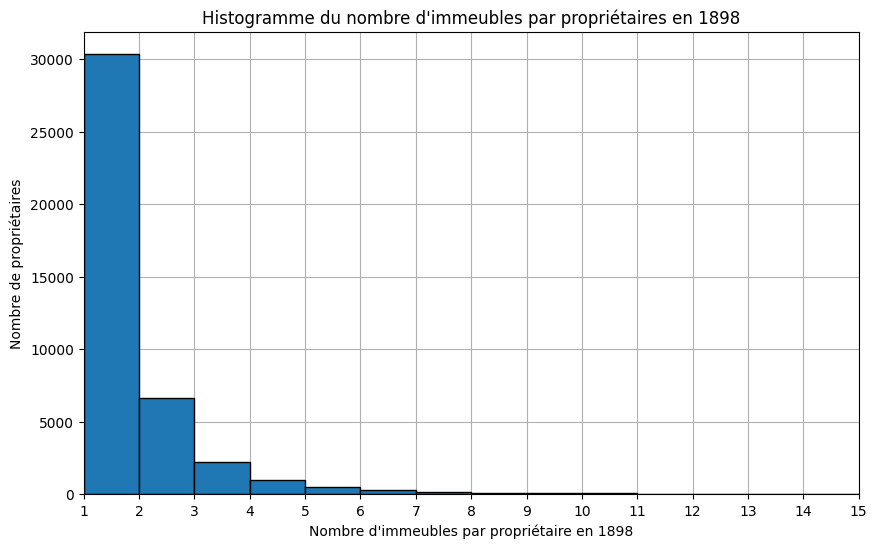

In [30]:
plt.figure(figsize=(10, 6))
plt.hist(df_proprio_1898['nb_imms'], bins=range(0, 16), edgecolor='black')
plt.title('Histogramme du nombre d\'immeubles par propriétaires en 1898')
plt.xlabel('Nombre d\'immeubles par propriétaire en 1898')
plt.ylabel('Nombre de propriétaires')
plt.grid(True)
plt.xticks(range(1, 16))
plt.xlim(1, 15)
plt.savefig(os.path.join(path_fig, "distr_imm_1898.jpeg"), dpi=200)
plt.show()

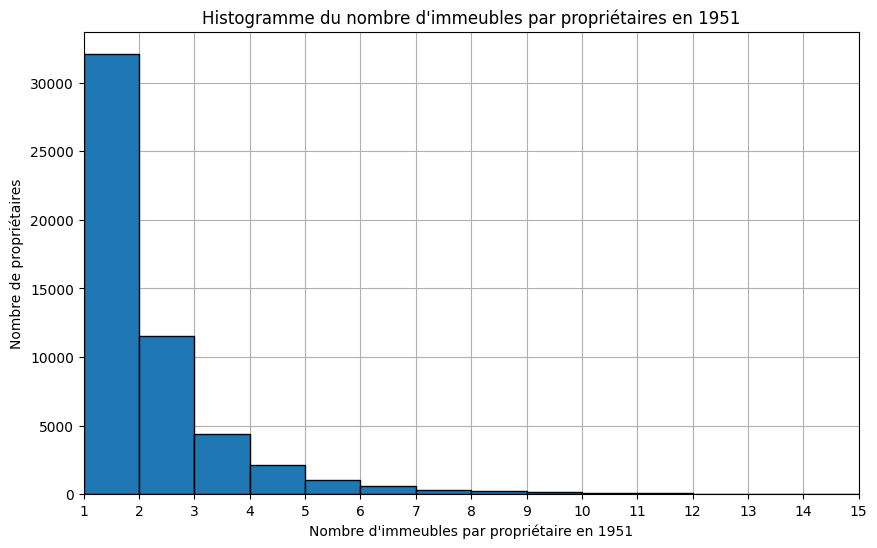

In [31]:
plt.figure(figsize=(10, 6))
plt.hist(df_proprio_1951['nb_imms'], bins=range(0, 16), edgecolor='black')
plt.title('Histogramme du nombre d\'immeubles par propriétaires en 1951')
plt.xlabel('Nombre d\'immeubles par propriétaire en 1951')
plt.ylabel('Nombre de propriétaires')
plt.grid(True)
plt.xticks(range(1, 16))
plt.xlim(1, 15)
plt.savefig(os.path.join(path_fig, "distr_imm_1951.jpeg"), dpi=200)
plt.show()

In [32]:
nb_1_1898 = len(df_proprio_1898.loc[df_proprio_1898['nb_imms'] == 1])
nb_1_1951 = len(df_proprio_1951.loc[df_proprio_1951['nb_imms'] == 1])
nb_2_1898 = len(df_proprio_1898.loc[df_proprio_1898['nb_imms'] == 2])
nb_2_1951 = len(df_proprio_1951.loc[df_proprio_1951['nb_imms'] == 2])
pourc_1 = round((nb_1_1951-nb_1_1898)*100/nb_1_1898, 2)
pourc_2 = round((nb_2_1951-nb_2_1898)*100/nb_2_1898, 2)

print(f"Nous avons {nb_1_1898} propriétaires qui possèdent un unique immeuble en 1898, contre {nb_1_1951} en 1951, ce qui correspond à une augmentation de {pourc_1}%.")
print(f"Et nous avons {nb_2_1898} propriétaires qui possèdent exactement deux immeubles en 1898, contre {nb_2_1951} en 1951, ce qui correspond à une augmentation de {pourc_2}%.")


Nous avons 30336 propriétaires qui possèdent un unique immeuble en 1898, contre 32081 en 1951, ce qui correspond à une augmentation de 5.75%.
Et nous avons 6658 propriétaires qui possèdent exactement deux immeubles en 1898, contre 11512 en 1951, ce qui correspond à une augmentation de 72.9%.


***


# Etape 3 : Etude de la copropriété

## A. Classement des données de l'annuaire de 1951 selon les trois types de copropriétaires existant dans ce document

L'annuaire de 1951 contient des propriétaires en situation de copropriété dans trois endroits différents :
- les entrées des personnes, ou "copropriétaire" est précisé. Dans ce cas, il devrait y avoir "copropriétaire" dans la colonne "part_pers"
- les sociétés immobilières, se situant de la page 445 à la page 478
- l'annexe "Copropriétaires", entre les pages 533 et 555

### 1. Les entrées qui ont une indication de copropriété dans la colonne "part_pers"

In [33]:
# On regarde le contenu de la colonne
df_imm_1951.part_pers.value_counts()

part_pers
(indivis)                      854
(copropriétaire)               786
taire)                         198
['(co.', 'propriétaire) -']    144
['(indivis)', '(indivis)']     136
                              ... 
(23)                             1
Ets),                            1
Emile)                           1
(cie d'Assurances 1')            1
Bleuets »                        1
Name: count, Length: 255, dtype: int64

In [34]:
# On remarque que les noms ne sont pas homogénéisés, donc on procède à une homogénéisation des contenus les plus fréquents
# Nous prenons en compte `indivision` et `copropriété`

# Définition du dictionnaire qui va nous servir à homogénéiser la colonne
dico_homo_part = {'(indivis)': 'indivision', "['(indivis)', '(indivis)']" : 'indivision', "(in-": 'indivision',
"(indi-": 'indivision', "(indivis]": 'indivision', "['(indivis)', '(in-']": 'indivision',

"['(co.', 'propriétaire) -']" : 'coproprietaire', '(copropriétaire)': 'coproprietaire',
"(copro-": 'coproprietaire', "propriétaire).": 'coproprietaire', "(coprop.)": 'coproprietaire',
"['(coproprié-', 'taire)']": 'coproprietaire', "(co-" : 'coproprietaire',
"['(copropriétaire)', '(copropriétaire)']": 'coproprietaire',
"['(copropriétaire)', '(copropriétaire)', '(copropriétaire)']": 'coproprietaire',
"(copropriétaire).": 'coproprietaire', "['(coproprié-', ['taire)', '(copropriétaire)']]": 'coproprietaire',
"['(copropriétaire)', '(copro-']": 'coproprietaire', "['(copropriétaire)', '(co-']": 'coproprietaire',
"['(co-', 'propriétaire) .', '(copropriétaire)']": 'coproprietaire', "['(copro-', 'priétaire) -']": 'coproprietaire',
"['(coprop.)', '(coprop.)']": 'coproprietaire', "(copropriétai-": 'coproprietaire', "['(co-', 'propriétaire) -']": 'coproprietaire',
"['(copropriétaire)', '(coproprié-', 'taire)']": 'coproprietaire',
"['(coproprié-', 'taire)', '(copropriétaire)', ['(copropriétaire)', '(co-'], 'propriétaire) -']": 'coproprietaire',
"['priétaire).', '(copropriétaire)']": 'coproprietaire', "propriétaire) .": 'coproprietaire',
"['(coproprié-', 'taire)', '(copropriétaire)']": 'coproprietaire'}

In [35]:
# Définition d'une fonction d'homogénéisation
def homoG(row):
    if row.part_pers in dico_homo_part.keys():
        return dico_homo_part[row.part_pers]

In [36]:
# Application de cette fonction
df_imm_1951['part_pers_homo'] = df_imm_1951.apply(homoG, axis=1)

In [37]:
# Résultats obtenus
df_imm_1951.part_pers_homo.value_counts()

part_pers_homo
coproprietaire    1560
indivision        1091
Name: count, dtype: int64

In [38]:
# On recupère aussi toutes les lignes qui ont 'copropriétaire' dans cette colonne. Idem pour indivision
df_imm_1951.loc[(df_imm_1951['part_pers_homo'].isna()) & (df_imm_1951['part_pers'].str.contains('copropriétaire', na=False)), 'part_pers_homo'] = 'coproprietaire'
df_imm_1951.loc[(df_imm_1951['part_pers_homo'].isna()) & (df_imm_1951['part_pers'].str.contains('indivis', na=False)), 'part_pers_homo'] = 'indivision'

In [39]:
df_imm_1951.part_pers_homo.value_counts()

part_pers_homo
coproprietaire    1743
indivision        1178
Name: count, dtype: int64

In [40]:
# On créé un dataframe contenant les propriétaires en situation de copropriété
df_copro1_proprio_1951 = df_imm_1951.loc[df_imm_1951.part_pers_homo == 'coproprietaire']

In [41]:
# Note : un immeuble en copropriété peut se trouver plusieurs fois dans la liste indexé par les propriétaires, une fois pour chaque copropriétaire
# Par exemple ici, l'immeuble au 1, rue Championnet existe deux fois dans nos données
df_imm_1951.loc[(df_imm_1951.num_imm == 238) & (df_imm_1951.code_voie_imm == 882)]

__index_pers__  quartier_pers  quartier_imm  index_total  \
5138            2485           55.0          69.0         2485   
5703            2792            NaN          69.0         2792   

                     nom_pers prenom_pers civilite_pers  org num_pers  \
5138                  Barraud   (Edmond),           NaN  NaN       23   
5703  ['Baudet', 'Vincennes']   (Maurice)           NaN  NaN       54   

     type_voie_pers      nom_voie_pers arr_pers ville_pers loc_pers  \
5138            rue  ['Daguer-', 're']    (14e)        NaN      NaN   
5703            rue              Massu      NaN        NaN  (Seine)   

             part_pers          codes  nb_codes   nveaux_codes       code  \
5138  (copropriétaire)  ['882 : 238']         1  ['882 : 238']  882 : 238   
5703              (co-  ['882 : 238']         1  ['882 : 238']  882 : 238   

      code_voie_imm liste_nums_imm  nb_nums_imm type_voie_imm nom_voie_imm  \
5138          882.0        ['238']          1.0           rue  championnet   
5703          882.0        ['238']          1.0           rue  championnet   

     arrs_imm  num_imm  nb_imms   lat_pers  lng_pers result_type_pers  \
5138       18    238.0        1  48.834023  2.329266      housenumber   
5703       18    238.0        1  48.848300  2.420874      housenumber   

     result_city_pers    lat_imm   lng_imm result_type_imm result_city_imm  \
5138            Paris  48.893302  2.328223     housenumber           Paris   
5703        Vincennes  48.893302  2.328223     housenumber           Paris   

                       coord_imm                    geometry  \
5138  POINT (2.328223 48.893302)  POINT (2.329266 48.834023)   
5703  POINT (2.328223 48.893302)    POINT (2.420874 48.8483)   

                      coord_pers  part_pers_homo  
5138  POINT (2.329266 48.834023)  coproprietaire  
5703    POINT (2.420874 48.8483)  coproprietaire

In [42]:
# Donc on fait un dataframe qui ne contient normalement qu'un exemplaire de chaque immeuble
df_copro1_imm_1951 = df_copro1_proprio_1951.drop_duplicates(subset=['code_voie_imm', 'num_imm'])

### 2. Les entrées des sociétés immobilières

In [43]:
# On a isole les entrées des sociétés immobilières, en utilisant les bornes correspondantes, pour le dataframe des proprietaires
df_copro2_soc_proprio_1951 = df_proprio_1951.iloc[45400:48213+1]
# Idem pour le dataframe des immeubles
df_copro2_soc_imm_1951 = df_imm_1951[(df_imm_1951['__index_pers__'] >= 45400) & (df_imm_1951['__index_pers__'] <= 48214)]

### 3. Les entrées de l'annexe "Copropriétaires"

In [44]:
# On a traité cette annexe à part ; on doit juste importer les données
df_copro3_imm_1951 = pd.read_csv('/home/aaron/Documents/M2/memoire_M2/0_Rendu_M2/df_annexe_copro_par_num_complet_1951.csv')
df_copro3_proprio_1951 = pd.read_csv('/home/aaron/Documents/M2/memoire_M2/0_Rendu_M2/df_annexe_copro_par_proprio_complet_1951.csv')

### 4. Quelques chiffres sur les différents types de copropriété dans l'annuaire

In [45]:
nb_copro1_imm = len(df_copro1_imm_1951)
nb_copro1_p = len(df_copro1_proprio_1951)
nb_copro2_p = len(df_copro2_soc_proprio_1951)
nb_copro2_imm = len(df_copro2_soc_imm_1951)
nb_copro3_imm = len(df_copro3_imm_1951)
nb_copro3_proprio = len(df_copro3_proprio_1951)

print(f"Nous avons :\n- {nb_copro1_imm} immeubles en copropriété dans la liste, qui correspondent à {nb_copro1_p} copropriétaires ;\n- {nb_copro2_p} sociétés immobilières, qui possèdent {nb_copro2_imm} immeubles ;\n- {nb_copro1_imm} immeubles en copropriété dans la liste, qui correspondent à {nb_copro1_p} copropriétaires.")

Nous avons :
- 1426 immeubles en copropriété dans la liste, qui correspondent à 1743 copropriétaires ;
- 2814 sociétés immobilières, qui possèdent 5991 immeubles ;
- 1426 immeubles en copropriété dans la liste, qui correspondent à 1743 copropriétaires.


In [46]:
# c'est extremement troublant qu'on trouve les memes valeurs pour les 2, copro1 et copro3
# pourtant c'est bien des valeurs differentes, car leurs distributions sont différentes :
df_copro1_imm_1951.quartier_imm.describe()

count    1401.000000
mean       45.059243
std        22.223605
min         1.000000
25%        28.000000
50%        44.000000
75%        64.000000
max        80.000000
Name: quartier_imm, dtype: float64

In [47]:
df_copro3_imm_1951.quartier_imm.describe()

count    3518.000000
mean       50.233371
std        19.248649
min         1.000000
25%        33.000000
50%        57.000000
75%        65.000000
max        80.000000
Name: quartier_imm, dtype: float64

In [48]:
# Après une seconde vérification sur la rue de Charenton, on constate qu'il s'agit bien de deux jeux d'informtation différents, car les numéros de la rue
# ne sont jamais dans les deux jeux de données à la fois :
# Dans la liste copro_1 (du corps de l'annuaire), on trouve les numeros suivants dans la rue de Charenton :
# 1, 6, 4, 8, 22, 54, 55, 72, 124, 153, 218, 220, 310

# Alors que dans la liste copro_3 (du l'annexe), on trouve les numeros suivants dans la rue de Charenton :
# 3, 42, 68, 87, 91, 110, 114, 126, 150, 158, 199, 201, 207, 242, 290

### 5. Rassemblement des types de copropriété

Nous rassemblons la liste copro_1, et la liste copro_3, car elles contiennent des informations de meme nature : des personnes qui possède des immeubles en co-propriété avec d'autres personnes, et qu n'utilisent pas une structure de société immobilière

In [49]:
# Nous comptons copro_1 et copro_3 en les ajoutant dans la meme colonne
gdf_quartiers['nb_imm_copro_pers_1951'] = df_copro1_imm_1951["quartier_imm"].value_counts().astype(int) + df_copro3_imm_1951["quartier_imm"].value_counts().astype(int)
gdf_quartiers['nb_proprio_copro_pers_1951'] = df_copro1_proprio_1951["quartier_pers"].value_counts().astype(int) + df_copro3_proprio_1951["quartier_pers"].value_counts().astype(int)

# Nous comptons aussi copro_2 dans une colonne à part
gdf_quartiers['nb_imm_copro_soc_1951'] = df_copro2_soc_imm_1951["quartier_imm"].value_counts().astype(int)
gdf_quartiers['nb_proprio_copro_soc_1951'] = df_copro2_soc_proprio_1951["quartier_pers"].value_counts().astype(int)

## B. Production de cartes et graphiques sur la copropriété

Nous nous intéressons désormais à deux types de copropriété :
- les sociétés immobilières
- tout ce qui est de la copropriété mais qui ne rentre pas dans les sociétés immobilières

### 1. La copropriété qui n'est pas des sociétés immobilières

In [50]:
base_map = folium.Map(location=[48.86, 2.345], zoom_start=12, tiles="CartoDB positron")

min = gdf_quartiers.nb_imm_copro_pers_1951.min()
max = gdf_quartiers.nb_imm_copro_pers_1951.max()

m = gdf_quartiers.explore(
    column="nb_imm_copro_pers_1951",
    cmap='Reds',
    m=base_map,
    tooltip=["c_qu", "nb_imm_copro_pers_1951", "nb_proprio_copro_pers_1951"],
    popup=True,
    categorical=False,
    vmin=min,
    vmax=max,
    style_kwds=dict(color="grey"),
    legend_kwds=dict(caption="Nombre d'immeubles possédés par des copropriétaires par quartier en 1951")
)
m.save(os.path.join(path_fig, "nb_imm_copro_pers_1951.html"))
m

In [51]:
gdf_quartiers.nb_proprio_copro_pers_1951.describe()

count    58.000000
mean     18.672414
std      13.389428
min       4.000000
25%       9.000000
50%      16.000000
75%      25.750000
max      69.000000
Name: nb_proprio_copro_pers_1951, dtype: float64

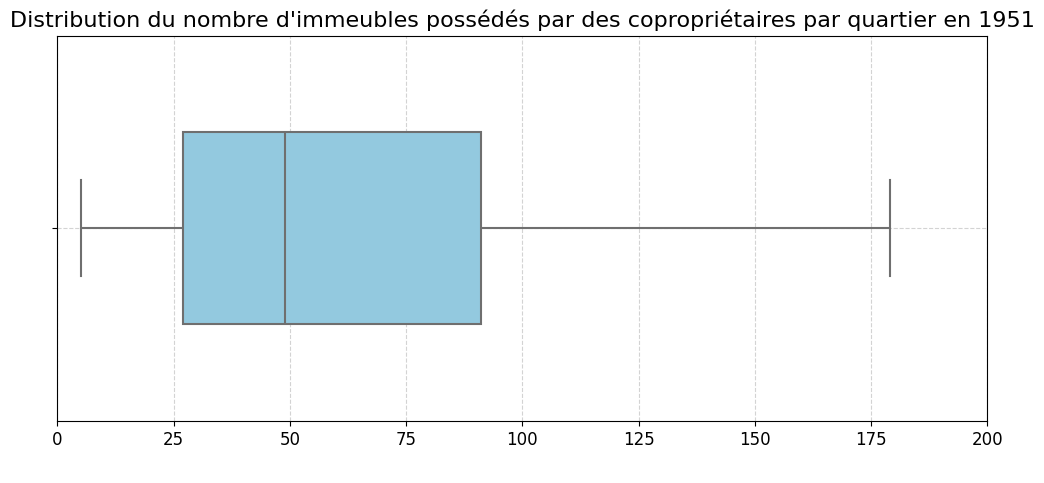

In [52]:
plt.figure(figsize=(12, 5))

sns.boxplot(x='nb_imm_copro_pers_1951', data=gdf_quartiers, color='skyblue', linewidth=1.5, width=0.5)

plt.xlabel(' ', fontsize=14)
plt.ylabel(' ', fontsize=14)
plt.title('Distribution du nombre d\'immeubles possédés par des copropriétaires par quartier en 1951', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(0, 200)

plt.grid(color='lightgrey', linestyle='--')  # Set grid color and linestyle

plt.savefig(os.path.join(path_fig, "distr_imm_copro_pers_1951.jpeg"), dpi=100)
plt.show()

### 2. Cartes et graphiques sur les sociétés immobilières

In [53]:
base_map = folium.Map(location=[48.86, 2.345], zoom_start=12, tiles="CartoDB positron")
min = gdf_quartiers.nb_imm_copro_soc_1951.min()
max = gdf_quartiers.nb_imm_copro_soc_1951.max()

m = gdf_quartiers.explore(
    column="nb_imm_copro_soc_1951",
    cmap='Reds',
    m=base_map,
    tooltip=["c_qu", "nb_imm_copro_soc_1951", "nb_proprio_copro_soc_1951"],
    popup=True,
    categorical=False,
    vmin=5,
    vmax=214,
    style_kwds=dict(color="grey"),
    legend_kwds=dict(caption="Nombre d'immeubles possédés par des sociétés immobilières par quartier en 1951")
)
m.save(os.path.join(path_fig, "nb_imm_copro_soc_1951.html"))
m

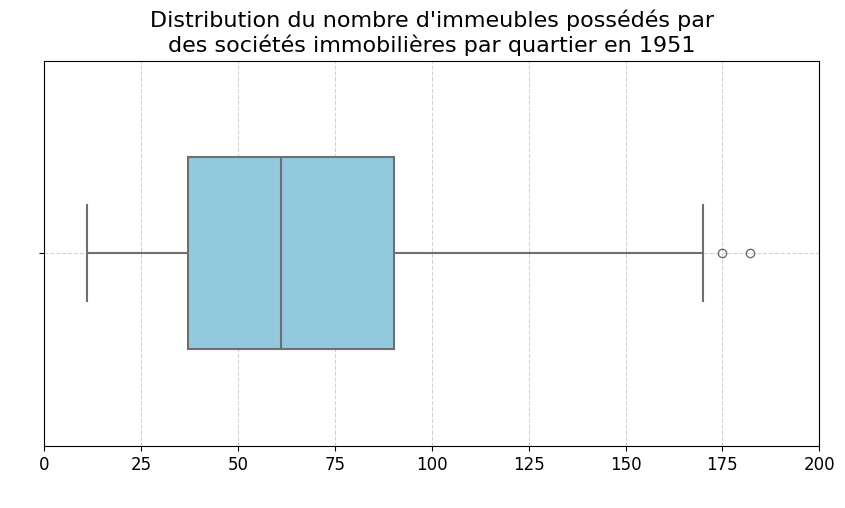

In [54]:
plt.figure(figsize=(10, 5))

sns.boxplot(x='nb_imm_copro_soc_1951', data=gdf_quartiers, color='skyblue', linewidth=1.5, width=0.5)

plt.xlabel(' ', fontsize=14)
plt.ylabel(' ', fontsize=14)
plt.title('Distribution du nombre d\'immeubles possédés par\ndes sociétés immobilières par quartier en 1951', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(0, 200)

plt.grid(color='lightgrey', linestyle='--')  # Set grid color and linestyle

plt.savefig(os.path.join(path_fig, "distr_imm_copro_soc_1951.jpeg"), dpi=100)
plt.show()

In [55]:
# Nous regardons les quartiers qui comporte plus de 200 immbeubles possédés par des sociétés immobilières
gdf_quartiers.loc[gdf_quartiers.nb_imm_copro_soc_1951 >= 200]

l_qu  c_ar     perimetre       surface  \
c_qu                                                    
57.0  Saint-Lambert  15.0   6928.792072  2.829202e+06   
61.0        Auteuil  16.0  12452.253931  6.383888e+06   
62.0         Muette  16.0  11962.438594  5.477898e+06   

                                               geometry  nb_immeubles_1898  \
c_qu                                                                         
57.0  POLYGON ((2.30425 48.84041, 2.30497 48.84061, ...             2105.0   
61.0  POLYGON ((2.24922 48.85783, 2.24959 48.85782, ...             1968.0   
62.0  POLYGON ((2.24562 48.87636, 2.25482 48.87408, ...             1701.0   

      nb_immeubles_1951  diff_nb_imm  densite_immeubles_1898  \
c_qu                                                           
57.0             3483.0       1378.0                0.000744   
61.0             3055.0       1087.0                0.000308   
62.0             2533.0        832.0                0.000311   

      densite_immeubles_1951  nb_imm_copro_pers_1951  \
c_qu                                                   
57.0                0.001231                   100.0   
61.0                0.000479                   167.0   
62.0                0.000462                   214.0   

      nb_proprio_copro_pers_1951  nb_imm_copro_soc_1951  \
c_qu                                                      
57.0                        30.0                    227   
61.0                        51.0                    429   
62.0                        69.0                    237   

      nb_proprio_copro_soc_1951  
c_qu                             
57.0                         76  
61.0                        122  
62.0                         68

***

# Etape 4 : Etude de la multi-propriété, en 1898 et 1951

## A. Quelques statistiques exploratoires

In [56]:
# distribution du nombre d'immeuble par multi-propriétaire en 1898
df_MP_proprio_1898.nb_imms.describe()

count    11205.000000
mean         3.194734
std          3.434280
min          2.000000
25%          2.000000
50%          2.000000
75%          3.000000
max        107.000000
Name: nb_imms, dtype: float64

In [57]:
# distribution du nombre d'immeuble par multi-propriétaire en 1951
df_MP_proprio_1951.nb_imms.describe()

count    20936.000000
mean         3.628917
std         16.949310
min          2.000000
25%          2.000000
50%          2.000000
75%          3.000000
max       1573.000000
Name: nb_imms, dtype: float64

In [58]:
df_MP_imm_1898 = df_imm_1898[df_imm_1898['code_total'].isin(df_MP_proprio_1898['code_total'])]
df_MP_imm_1951 = df_imm_1951[df_imm_1951['__index_pers__'].isin(df_MP_proprio_1951['__index_pers__'])]

In [59]:
nb_p_1898 = len(df_MP_proprio_1898)
nb_imm_1898 = len(df_MP_imm_1898)
nb_p_1951 = len(df_MP_proprio_1951)
nb_imm_1951 = len(df_MP_imm_1951)

print(f"Nous observons :\n- {nb_p_1898} multi-propriétaires en 1898, qui possèdent en tout {nb_imm_1898} immeubles ;\n- {nb_p_1951} multi-propriétaires en 1951, qui possèdent en tout {nb_imm_1951} immeubles.")

Nous observons :
- 11205 multi-propriétaires en 1898, qui possèdent en tout 35797 immeubles ;
- 20936 multi-propriétaires en 1951, qui possèdent en tout 75975 immeubles.


In [60]:
gdf_quartiers['nb_MP_proprio_1898'] = df_MP_proprio_1898.quartier_pers.value_counts().astype(int)
gdf_quartiers['nb_MP_proprio_1951'] = df_MP_proprio_1951.quartier_pers.value_counts().astype(int)

In [61]:
gdf_quartiers['nb_MP_proprio_1898'].describe()

count     80.000000
mean     133.550000
std       74.104938
min       33.000000
25%       74.500000
50%      122.000000
75%      180.250000
max      413.000000
Name: nb_MP_proprio_1898, dtype: float64

In [62]:
gdf_quartiers['nb_MP_proprio_1951'].describe()

count     80.000000
mean      93.312500
std       69.626416
min       12.000000
25%       35.750000
50%       73.000000
75%      138.250000
max      297.000000
Name: nb_MP_proprio_1951, dtype: float64

## B. Production de cartes sur la multi-propriété

### 1. Cartes sur le nombre de domicile de multi-propriétaire par quartier en 1898, puis en 1951

In [63]:
base_map = folium.Map(location=[48.86, 2.345], zoom_start=12, tiles="CartoDB positron")

min = gdf_quartiers.nb_MP_proprio_1898.min()
max = gdf_quartiers.nb_MP_proprio_1898.max()

m = gdf_quartiers.explore(
    column="nb_MP_proprio_1898",
    cmap='Reds',
    m=base_map,
    tooltip=["c_qu", "nb_MP_proprio_1898"],
    popup=True,
    categorical=False,
    vmin=min,
    vmax=max,
    style_kwds=dict(color="grey"),
    legend_kwds=dict(caption="Nombre de domiciles de multi-propriétaires par quartier en 1898")
)
m.save(os.path.join(path_fig, "nb_MP_proprio_1898.html"))
m

In [64]:
base_map = folium.Map(location=[48.86, 2.345], zoom_start=12, tiles="CartoDB positron")

min = gdf_quartiers.nb_MP_proprio_1951.min()
max = gdf_quartiers.nb_MP_proprio_1951.max()

m = gdf_quartiers.explore(
    column="nb_MP_proprio_1951",
    cmap='Reds',
    m=base_map,
    tooltip=["c_qu", "nb_MP_proprio_1951"],
    popup=True,
    categorical=False,
    vmin=min,
    vmax=max,
    style_kwds=dict(color="grey"),
    legend_kwds=dict(caption="Nombre de domiciles de multi-propriétaires par quartier en 1951")
)
m.save(os.path.join(path_fig, "nb_MP_proprio_1951.html"))
m

In [65]:
gdf_quartiers['nb_MP_imm_1898'] = df_MP_imm_1898.quartier_imm.value_counts().astype(int)
gdf_quartiers['nb_MP_imm_1951'] = df_MP_imm_1951.quartier_imm.value_counts().astype(int)

In [66]:
gdf_quartiers['nb_MP_imm_1898'].describe()

count      80.000000
mean      442.000000
std       268.034099
min        87.000000
25%       208.750000
50%       363.500000
75%       583.500000
max      1074.000000
Name: nb_MP_imm_1898, dtype: float64

In [67]:
gdf_quartiers['nb_MP_imm_1951'].describe()

count      80.000000
mean      932.137500
std       512.932071
min       237.000000
25%       522.750000
50%       796.000000
75%      1205.250000
max      2419.000000
Name: nb_MP_imm_1951, dtype: float64

### 2. Cartes sur le nombre d'immeubles possédés par des multi-propriétaires par quartier en 1898

In [68]:
base_map = folium.Map(location=[48.86, 2.345], zoom_start=12, tiles="CartoDB positron")

min = gdf_quartiers.nb_MP_imm_1898.min()
max = gdf_quartiers.nb_MP_imm_1898.max()

m = gdf_quartiers.explore(
    column="nb_MP_imm_1898",
    cmap='Reds',
    m=base_map,
    tooltip=["c_qu", "nb_MP_imm_1898"],
    popup=True,
    categorical=False,
    vmin=min,
    vmax=max,
    style_kwds=dict(color="grey"),
    legend_kwds=dict(caption="Nombre d'immeubles possédés par des multi-propriétaires par quartier en 1898")
)
m.save(os.path.join(path_fig, "nb_MP_imm_1898.html"))
m

In [69]:
base_map = folium.Map(location=[48.86, 2.345], zoom_start=12, tiles="CartoDB positron")

min = gdf_quartiers.nb_MP_imm_1951.min()
max = gdf_quartiers.nb_MP_imm_1951.max()

m = gdf_quartiers.explore(
    column="nb_MP_imm_1951",
    cmap='Reds',
    m=base_map,
    tooltip=["c_qu", "nb_MP_imm_1951"],
    popup=True,
    categorical=False,
    vmin=min,
    vmax=max,
    style_kwds=dict(color="grey"),
    legend_kwds=dict(caption="Nombre d'immeubles possédés par des multi-propriétaires par quartier en 1951")
)
m.save(os.path.join(path_fig, "nb_MP_imm_1951.html"))
m

## C. Analyse des dynamiques de multi-propriété au niveau des quartiers

Nos données nous permettent d'associer, d'une part, les quartiers des domiciles des propriétaires (quartier_pers), et d'autre part, les quartiers des immeubles que ces propriétaires possèdent (quartier_imm). Nous nous demandons maintenant si parmi ces combinaisons quatier personne - quartier immeuble, certaines sont plus fréquentes que les autres.

In [70]:
# Nous faisons des matrices qui font correspondre les quartier des immeubles à ceux des multi-propriétaires pour 1898 et 1951
pivot_table_1898 = df_MP_imm_1898.groupby(['quartier_imm', 'quartier_pers']).size().unstack(fill_value=0)
pivot_table_1898 = pivot_table_1898.reindex(range(1, 81), axis=0, fill_value=0)
pivot_table_1898 = pivot_table_1898.reindex(range(1, 81), axis=1, fill_value=0)

pivot_table_1951 = df_MP_imm_1951.groupby(['quartier_imm', 'quartier_pers']).size().unstack(fill_value=0)
pivot_table_1951 = pivot_table_1951.reindex(range(1, 81), axis=0, fill_value=0)
pivot_table_1951 = pivot_table_1951.reindex(range(1, 81), axis=1, fill_value=0)

# lignes = quartier_imm
# colonnes = quartier_pers

### 1. Comparaison avec tous les quartiers

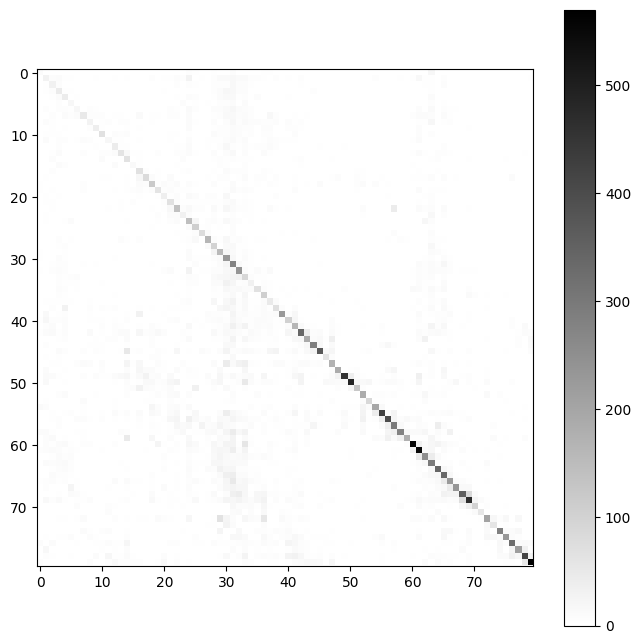

In [71]:
plt.figure(figsize=(8, 8))
plt.imshow(pivot_table_1898, cmap='gray_r')
plt.colorbar()
plt.savefig(os.path.join(path_fig, 'matrice_quartier_MP_diag_1898.png'))
plt.show()

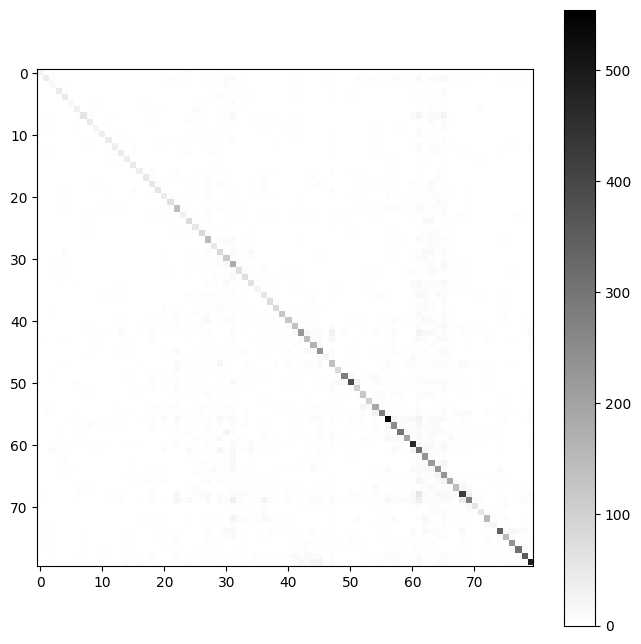

In [72]:
plt.figure(figsize=(8, 8))
plt.imshow(pivot_table_1951, cmap='gray_r')
plt.colorbar()
plt.savefig(os.path.join(path_fig, 'matrice_quartier_MP_diag_1951.png'))
plt.show()

In [73]:
sum_diagonal_1898 = np.trace(pivot_table_1898)
sum_total_1898 = pivot_table_1898.values.sum()
perc_diagonal_1898 = round((sum_diagonal_1898 / sum_total_1898) * 100, 2)

sum_diagonal_1951 = np.trace(pivot_table_1951)
sum_total_1951 = pivot_table_1951.values.sum()
perc_diagonal_1951 = round((sum_diagonal_1951 / sum_total_1951) * 100, 2)

print(f"Parmi les immeubles possédés par des multi-propriétaires :\n- {perc_diagonal_1898}% sont possédés par des multi-propriétaires qui habitent dans le meme quartier en 1898 ;\n- {perc_diagonal_1951}% en 1951.")

Parmi les immeubles possédés par des multi-propriétaires :
- 42.44% sont possédés par des multi-propriétaires qui habitent dans le meme quartier en 1898 ;
- 49.2% en 1951.


Nous remarquons que les immeubles possédés par des multi-propriétaires sont très souvent dans le meme quartier que leur domicile : entre 42% et 50%, alors que ces cas ne correspondent qu'à 1/80 = 1.25% de toutes les combinaisons possibles. Nous allons donc écarter ces cas pour y voir plus clair.

### 2. Comparaison sans les cas ou le quartier de l'immeuble et du domicile sont les memes

In [74]:
np.fill_diagonal(pivot_table_1898.values, 0)
np.fill_diagonal(pivot_table_1951.values, 0)

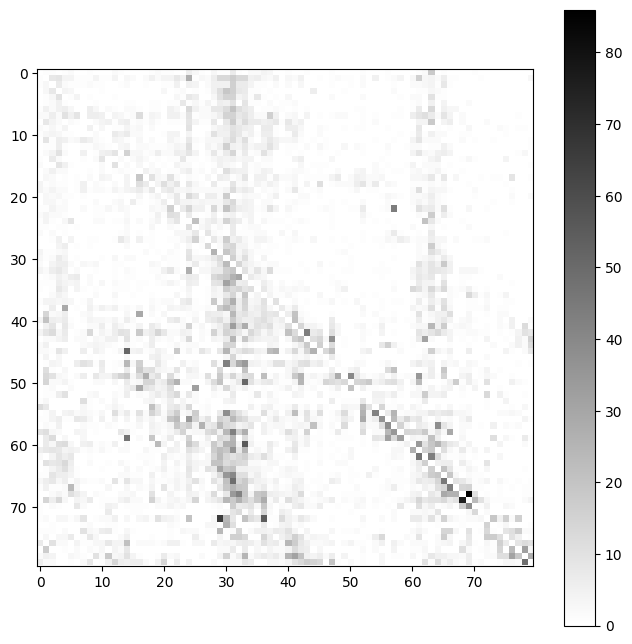

In [75]:
plt.figure(figsize=(8, 8))
plt.imshow(pivot_table_1898, cmap='gray_r')
plt.colorbar()
plt.savefig(os.path.join(path_fig, 'matrice_quartier_MP_ss_diag_1898.png'))
plt.show()

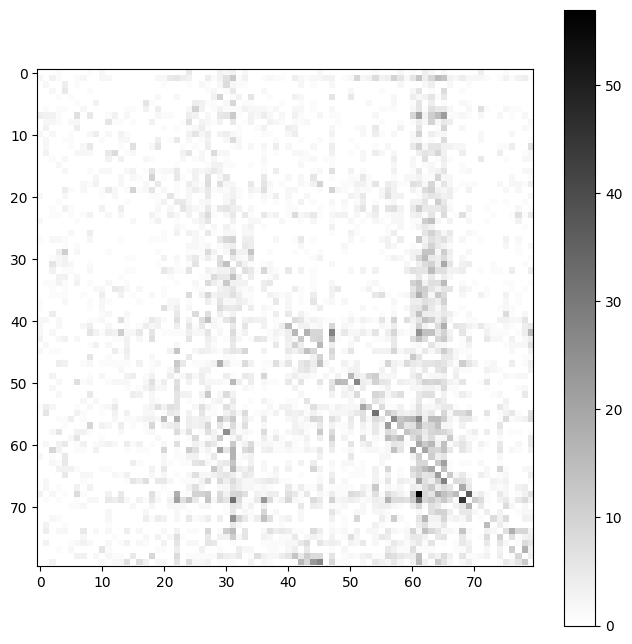

In [76]:
plt.figure(figsize=(8, 8))
plt.imshow(pivot_table_1951, cmap='gray_r')
plt.colorbar()
plt.savefig(os.path.join(path_fig, 'matrice_quartier_MP_ss_diag_1951.png'))
plt.show()

Nous remarquons certaines taches qui montrent des tendances de possession d'immeubles dans certains quartiers et de domiciliations dans certains autres. En particulier, nous remarquons que beaucoup de propriétaires possèdent des immeubles dans les quartiers 24 à 35, et habitent dans les quartiers 54 à 75, pour l'année 1898.

Pour l'année 1951, nous remarquons des dynamiques similaires, mais pour des propriétaires possédant des immeubles dans les quartiers 59 à 67, et habitant dans les quartiers 53 à 69.

Nous allons regarder ou se situent ces différents quartiers

### 3. Production de cartes pour situer les quartiers mis en exergue dans les graphiques précédents

In [77]:
ss_gdf_25_35 = gdf_quartiers.iloc[24:35]
ss_gdf_25_35['qu'] = 0.5

base_map = folium.Map(location=[48.86, 2.345], zoom_start=12, tiles="CartoDB positron")

m = ss_gdf_25_35.explore(
    column="qu",
    cmap='Reds',
    m=base_map,
    tooltip=["c_ar", "nb_MP_imm_1951"],
    popup=True,
    # categorical=False,
    vmin=0,
    vmax=1,
    style_kwds=dict(color="grey"),
    legend_kwds=dict(caption="Quartiers 25 à 35")
)
m.save(os.path.join(path_fig, "qu_25_35.html"))
m

/home/aaron/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [78]:
ss_gdf_55_75 = gdf_quartiers.iloc[54:75]
ss_gdf_55_75['qu'] = 0.5

base_map = folium.Map(location=[48.86, 2.345], zoom_start=12, tiles="CartoDB positron")

m = ss_gdf_55_75.explore(
    column="qu",
    cmap='Reds',
    m=base_map,
    tooltip=["c_ar", "nb_MP_imm_1951"],
    popup=True,
    # categorical=False,
    vmin=0,
    vmax=1,
    style_kwds=dict(color="grey"),
    legend_kwds=dict(caption="Quartiers 55 à 75")
)
m.save(os.path.join(path_fig, "qu_55_75.html"))
m

/home/aaron/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [79]:
ss_gdf_60_67 = gdf_quartiers.iloc[59:67]
ss_gdf_60_67['qu'] = 0.5

base_map = folium.Map(location=[48.86, 2.345], zoom_start=12, tiles="CartoDB positron")

m = ss_gdf_60_67.explore(
    column="qu",
    cmap='Reds',
    m=base_map,
    tooltip=["c_ar", "nb_MP_imm_1951"],
    popup=True,
    # categorical=False,
    vmin=0,
    vmax=1,
    style_kwds=dict(color="grey"),
    legend_kwds=dict(caption="Quartiers 60 à 67")
)
m.save(os.path.join(path_fig, "qu_60_67.html"))
m

/home/aaron/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [80]:
ss_gdf_54_69 = gdf_quartiers.iloc[53:69]
ss_gdf_54_69['qu'] = 0.5

base_map = folium.Map(location=[48.86, 2.345], zoom_start=12, tiles="CartoDB positron")

m = ss_gdf_54_69.explore(
    column="qu",
    cmap='Reds',
    m=base_map,
    tooltip=["c_ar", "nb_MP_imm_1951"],
    popup=True,
    # categorical=False,
    vmin=0,
    vmax=1,
    style_kwds=dict(color="grey"),
    legend_kwds=dict(caption="Quartiers 54 à 69")
)
m.save(os.path.join(path_fig, "qu_54_69.html"))
m

/home/aaron/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### 4. Zoom sur les immeubles du quartier 61 (dans le 16e arrondissement) qui sont possédés par des multi-propriétaires habitant dans le quartier 34 (9e arr.)

In [81]:
# On a 56 immeubles du quartier 61 (16e) qui sont possedes par des gens habitant dans le quartier 34 (9e)
len(df_MP_imm_1898.loc[(df_MP_imm_1898.quartier_pers == 34) & (df_MP_imm_1898.quartier_imm == 61)])

56

In [82]:
sub_gdf = df_MP_imm_1898.loc[(df_MP_imm_1898.quartier_pers == 34) & (df_MP_imm_1898.quartier_imm == 61)]

In [83]:
# Quel profil des proprietaires ? est-ce qu'on a plein de multi-P ou des gens qui reviennent plusieurs fois ?
sub_gdf.code_pers.value_counts()

code_pers
18705.0    19
21663.0    12
24768.0     4
25879.0     3
17721.0     3
9814.0      3
10463.0     2
40058.0     2
3036.0      2
13898.0     2
13897.0     2
28641.0     1
32931.0     1
Name: count, dtype: int64

On remarque qu'on a surtout des personnes qui possèdent moins de 4 immeubles ; mais on a également deux personnes qui possèdent la majorité des immeubles. On se penche sur la première personne, qui en posséde 19.

#### Nous faisons une carte des immeubles de M. Lambert (code pers 18705.0)

In [84]:
df_proprio_1898.loc[df_proprio_1898.code_pers == 18705.0]

new_index  index_left  index    code_voie_quartiers_imm code_voie_imm  \
8150      12434        73.0    NaN  C.460 CURE (Rue de la) 61         C.460   

     liste_numeros_imm numero_imm type_voie_imm nom_voie_imm nb_imm  \
8150                14         14           rue         cure      1   

      quartier_imm quartiers_imm  quartier_in_quartiers_imm  \
8150          61.0            61                       True   

      bool_quartiers_multiples complement_nom_voie_imm precisions_imm  \
8150                     False                       0              0   

     num_pers type_voie_pers nom_voie_pers  quartier_pers nom_pers  \
8150       10            rue         auber           34.0  Lambert   

     prenom_pers civilite_pers  code_pers desamb_pers ville_pers  \
8150           0             0    18705.0           0      Paris   

     departement_pers ger org org_hom  code_org code_secteur_activite_org rem  \
8150                0   0   0       0       0.0                         0   0   

     entree_imm  Entree=0.1_Parisien=1.0_Nonparisien=0.0    lat_imm   lng_imm  \
8150          0                                      1.0  48.853184  2.267983   

                       coord_imm result_type_imm result_city_imm   lat_pers  \
8150  POINT (2.267983 48.853184)     housenumber           Paris  48.872653   

      lng_pers                  coord_pers result_type_pers result_city_pers  \
8150  2.329292  POINT (2.329292 48.872653)      housenumber            Paris   

      meme_adresse meme_quartier  code_total  nb_imms  
8150         False         False     18705.0     22.0

In [85]:
df_lambert = df_imm_1898.loc[df_imm_1898.code_pers == 18705.0]

In [86]:
len(df_lambert)

22

In [87]:
df_lambert.quartier_imm.value_counts()

quartier_imm
61.0    19
59.0     3
Name: count, dtype: int64

In [88]:
gdf_quartiers.iloc[58:61]

l_qu  c_ar     perimetre       surface  \
c_qu                                               
59.0  Grenelle  15.0   4932.937240  1.478299e+06   
60.0     Javel  15.0   8068.977385  2.609009e+06   
61.0   Auteuil  16.0  12452.253931  6.383888e+06   

                                               geometry  nb_immeubles_1898  \
c_qu                                                                         
59.0  POLYGON ((2.30088 48.85118, 2.30088 48.85118, ...             1666.0   
60.0  POLYGON ((2.28233 48.83495, 2.28390 48.83437, ...             1206.0   
61.0  POLYGON ((2.24922 48.85783, 2.24959 48.85782, ...             1968.0   

      nb_immeubles_1951  diff_nb_imm  densite_immeubles_1898  \
c_qu                                                           
59.0             2048.0        382.0                0.001127   
60.0             1548.0        342.0                0.000462   
61.0             3055.0       1087.0                0.000308   

      densite_immeubles_1951  nb_imm_copro_pers_1951  \
c_qu                                                   
59.0                0.001385                    87.0   
60.0                0.000593                   110.0   
61.0                0.000479                   167.0   

      nb_proprio_copro_pers_1951  nb_imm_copro_soc_1951  \
c_qu                                                      
59.0                        18.0                    126   
60.0                        21.0                     63   
61.0                        51.0                    429   

      nb_proprio_copro_soc_1951  nb_MP_proprio_1898  nb_MP_proprio_1951  \
c_qu                                                                      
59.0                         38                 117                 150   
60.0                         12                  78                  95   
61.0                        122                 224                 274   

      nb_MP_imm_1898  nb_MP_imm_1951  
c_qu                                  
59.0             764            1452  
60.0             564            1176  
61.0            1013            2059

Il possède 22 immeubles en tout : 2 dans le quartier 59, dans le 15e arr., et 19 dans le quartier 61, dans le 16e arr.

In [89]:
# On représente ses immeubles : ceux de Auteuil en vert, ceux de Grenelle en bleu
# Et on représente son domicile en rouge
m = folium.Map(location=[48.86, 2.345], zoom_start=12, tiles="CartoDB positron")

folium.TileLayer('cartodbpositron').add_to(m)

marker_cluster = m
# marker_cluster = MarkerCluster().add_to(m)

for idx, row in df_lambert.iterrows():
    if row['quartier_imm'] == 61:
        folium.Marker(location=[row['lat_imm'], row['lng_imm']], icon=folium.Icon(color="green")).add_to(marker_cluster)
    else:
        folium.Marker(location=[row['lat_imm'], row['lng_imm']], icon=folium.Icon(color="blue")).add_to(marker_cluster)

folium.Marker(location=[row['lat_pers'], row['lng_pers']], icon=folium.Icon(color="red")).add_to(marker_cluster)

m.save(os.path.join(path_fig, 'lambert.html'))
m


M. Lambert habite dans le 9e et possede 22 imm, uniquement dans le 15e et 16e

Nous faisons la meme chose pour M. Lerolle (code pers 30298)

In [90]:
df_lerolle = df_MP_imm_1951.loc[df_MP_imm_1951.__index_pers__ == 30298]

m = folium.Map(location=[48.86, 2.345], zoom_start=12, tiles="CartoDB positron")
folium.TileLayer('cartodbpositron').add_to(m)
marker_cluster = m

for idx, row in df_lerolle.iterrows():
    folium.Marker(location=[row['lat_imm'], row['lng_imm']], icon=folium.Icon(color="green")).add_to(marker_cluster)
folium.Marker(location=[48.870533,2.278583], icon=folium.Icon(color="red")).add_to(marker_cluster)

m.save(os.path.join(path_fig, 'lerolle.html'))
m


In [91]:
df_lerolle.quartier_imm.value_counts()

quartier_imm
61.0    11
73.0     9
36.0     1
70.0     1
Name: count, dtype: int64

Nous faisons finalement une carte comportant tous les quartiers administratifs

In [92]:
gdf_quartiers["col"] = 0.25

base_map = folium.Map(location=[48.86, 2.345], zoom_start=12, tiles="CartoDB positron")

m = gdf_quartiers.explore(
    column="col",
    cmap='Reds',
    m=base_map,
    tooltip=["c_qu", "nb_immeubles_1898", "nb_immeubles_1951"],
    popup=True,
    # categorical=False,
    vmin=0,
    vmax=1,
    style_kwds=dict(color="grey"),
    legend_kwds=dict(caption="Les quartiers administratifs")
)
m.save(os.path.join(path_fig, "quartiers.html"))
m